In [149]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Literal, List, Iterable

In [5]:
df = pd.read_csv(".\website_ab_test.csv")

Набор данных содержит метрики пользовательского поведения в приложении со светлой и темной темой. 
Используем данные для имитации A/b тестирования. Представим, что в приложении была только светлая тема. Синтезируем выборку для A/A теста из этой группы. Проведем расчеты: определим размер выборок для A\B теста, определим детектируемый эффект и ошибки 1 и 2 рода. Проверим группы пользователей на однородность, затем синтезируем выборки для A/B теста из датасета и проверим гипотезы. 

In [6]:
df.head()

,Theme,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Location,Session_Duration,Purchases,Added_to_Cart
0,Light Theme,0.054920,0.282367,0.405085,72.489458,25,Chennai,1535,No,Yes
1,Light Theme,0.113932,0.032973,0.732759,61.858568,19,Pune,303,No,Yes
2,Dark Theme,0.323352,0.178763,0.296543,45.737376,47,Chennai,563,Yes,Yes
3,Light Theme,0.485836,0.325225,0.245001,76.305298,58,Pune,385,Yes,No
4,Light Theme,0.034783,0.196766,0.765100,48.927407,25,New Delhi,1437,No,No


In [7]:
df.shape

(1000, 10)

In [8]:
df['Theme'].value_counts()

Theme
Dark Theme     514
Light Theme    486
Name: count, dtype: int64

Конверсия - наиболее интересная для бизнеса метрика из приведенных в таблице. Но так как выборка малая, сложно будет оценить конверсию, для этой метрики обычно характерен малый прирост в зависимости от изменений интерфейса, но на выборке в пределах 500 человек колебания в несколько процентов будут 'заглушаться' ошибкой, связанной в том числе с разной лояльностью пользователей, частотой заказов и длительностью использования приложения, другими признаками, которых в исходных данных нет. В таком случае также не можем обеспечить однородность групп без дополнительных данных о пользователях и ожидать от A/B теста достоверный результат.

Поэтому на мой взгляд, такие данные могли быть предоставлены для анализа метрик пользовательского поведения. Вопросы бизнеса могли звучать так: стали ли пользователи больше времени проводить в приложении с появлением темной темы? Стало ли им комфортнее делать заказы, просматривать товары?
Гипотезы и исследование будем строить исходя из такого предположения о происхождении данных и цели исследования. 

In [68]:
light_df = df.loc[df['Theme'] == "Light Theme"]
dark_df = df.loc[df['Theme'] == "Dark Theme"]

# Статистический анализ, корреляционный анализ метрик

Сгенерируем случайную выборку пользователей со светлой темой, которая будет исходной: рассчитаем исторические данные (текущие метрики, статистики), проведем A\A тест.   

In [69]:
sample_380 = light_df.sample(n=380, random_state=42)

In [12]:
def create_stats_df(df):
    '''
    Создает сводную таблицу статистик для столбцов из df pandas
    '''
    stats = {}

    for column in df.columns:
        series = df[column] 

        stats[column] = {
            'Среднее': series.mean(),
            'Дисперсия': series.var(),
            'Мода': series.values[0],
            'Медиана': series.median(),
            '1-й квартиль': series.quantile(0.25),
            '2-й квартиль': series.quantile(0.50),
            '3-й квартиль': series.quantile(0.75),
            '4-й квартиль': series.quantile(1.0)
        }

    return pd.DataFrame(stats)

In [99]:
metrics_df = sample_380[['Click Through Rate', 'Bounce Rate', 'Scroll_Depth', 'Conversion Rate', 'Session_Duration']]

In [100]:
stats_df = create_stats_df(metrics_df)

In [101]:
stats_df

,Click Through Rate,Bounce Rate,Scroll_Depth,Conversion Rate,Session_Duration
Среднее,0.241117,0.493956,50.136691,0.252776,936.834211
Дисперсия,0.018503,0.028498,294.895255,0.018559,269812.333919
Мода,0.206408,0.317859,22.310718,0.244725,1734.000000
Медиана,0.230825,0.485023,51.042900,0.251678,959.500000
1-й квартиль,0.127635,0.344202,34.803340,0.137871,462.500000
2-й квартиль,0.230825,0.485023,51.042900,0.251678,959.500000
3-й квартиль,0.343400,0.635332,64.744063,0.372875,1416.000000
4-й квартиль,0.499328,0.797683,79.997108,0.498660,1797.000000


In [ ]:
def create_plots(df,  plots = List[Literal['pairplot', 'heatmap', 'histplot', 'boxplot', 'qqplot']]):
    '''
    Строит графики для распределений данных колонок переданного pd.DataFrame
    '''

    if 'pairplot' in plots:
        sns.pairplot(df,
                    plot_kws={'s': 20, 'alpha': 0.6})
        plt.show()
    
    if 'heatmap' in plots:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        #корреляция Спирмана
        spearman_corr = df.corr('spearman')
        mask = np.tril(np.ones_like(spearman_corr, dtype=bool))
        sns.heatmap(spearman_corr, annot = True, fmt='.2f', ax=axes[0], mask=mask)
        axes[0].set_title('Корреляция Спирмана')

        #корреляция Пирсона
        pearson_corr = df.corr()
        mask = np.tril(np.ones_like(pearson_corr, dtype=bool))
        sns.heatmap(pearson_corr, annot = True, fmt='.2f', ax=axes[1], mask=mask)
        axes[1].set_title('Корреляция Пирсона')

        plt.tight_layout()
        plt.show()

    if 'histplot' in plots:
        fig, axes = plt.subplots(1, len(df.columns), figsize=(15, 4))
        plt.suptitle('Плотность распределения', fontsize=16)
        for i, column in enumerate(df.columns):
            sns.histplot(data = df, x=column, ax=axes[i], bins = 50, kde = True)
        plt.tight_layout()
        plt.show()

    if 'boxplot' in plots:
        fig, axes = plt.subplots(1, len(df.columns), figsize=(15, 4))
        plt.suptitle('Квартили распределения', fontsize=16)
        for i, column in enumerate(df.columns):
            sns.boxplot(data=df, y = column, ax=axes[i])
        plt.tight_layout()
        plt.show()

    if 'qqplot' in plots:
        fig, axes = plt.subplots(1, len(df.columns), figsize = (15, 4))
        plt.suptitle('QQplot', fontsize = 16)
        for i, column in enumerate(df.columns):
            sts.probplot(df[column], plot = axes[i])
            axes[i].set_title(column)
        plt.tight_layout()
        plt.show()  

             

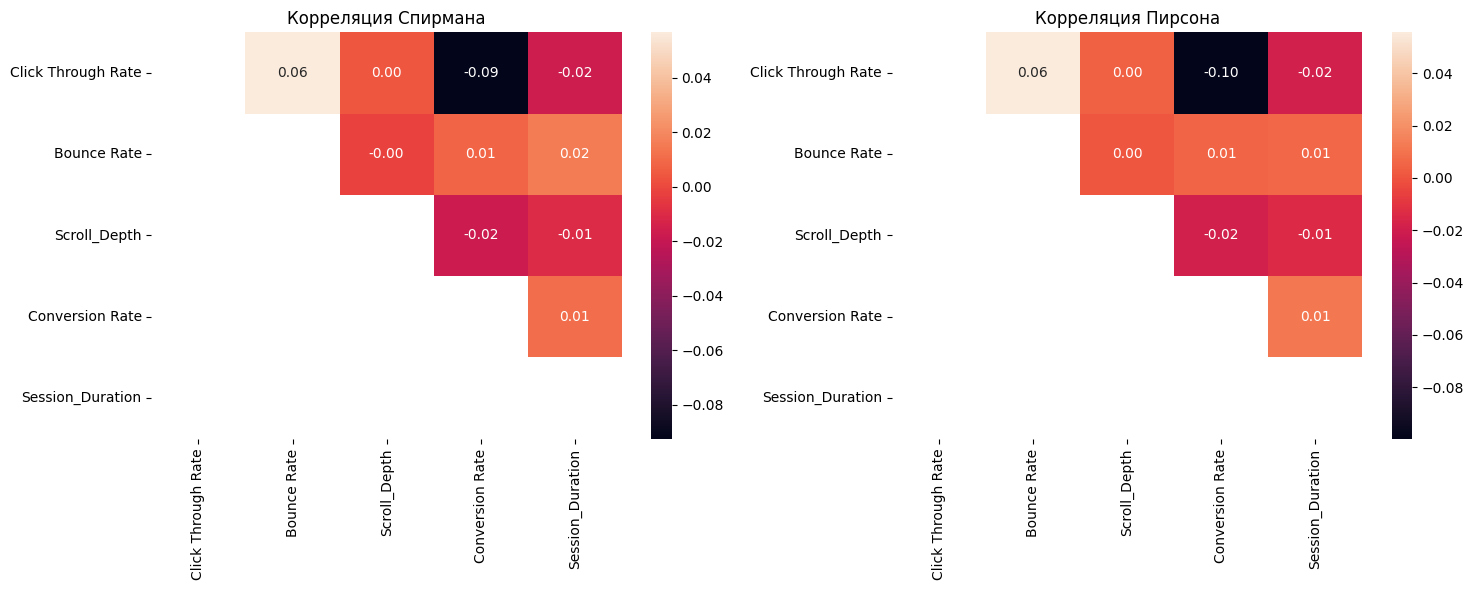

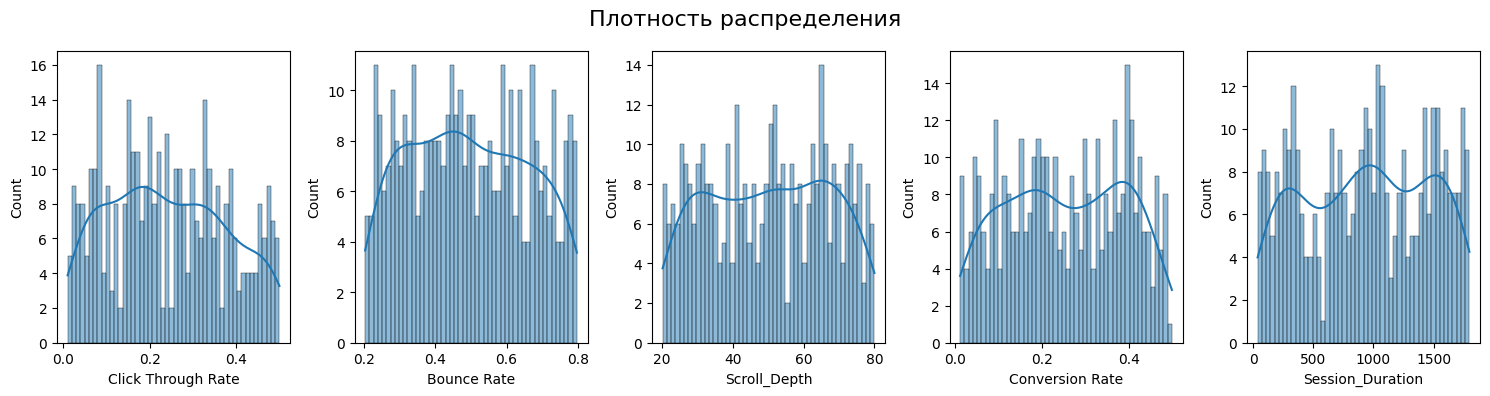

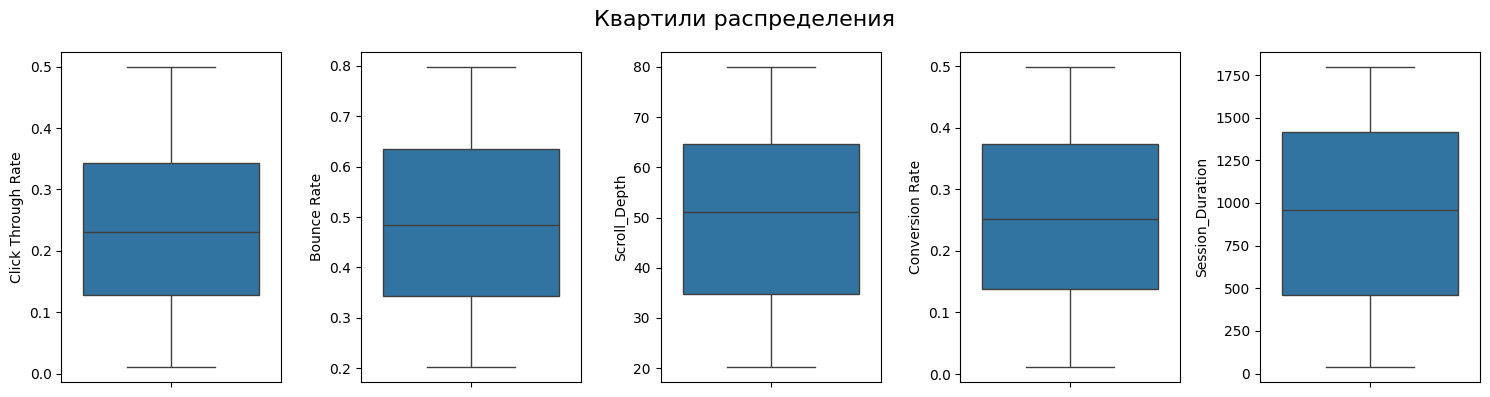

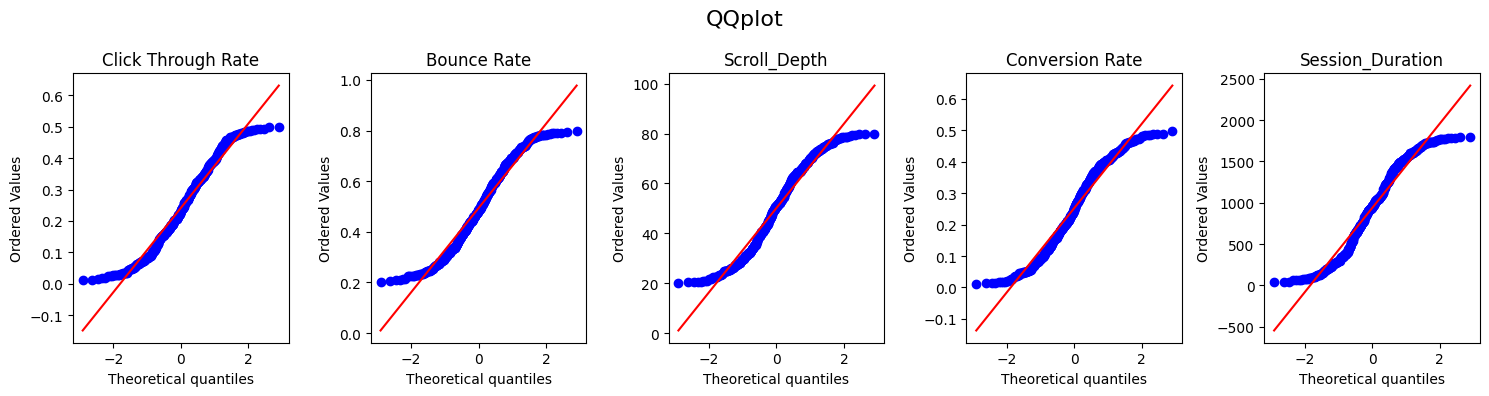

In [103]:
create_plots(metrics_df, ['heatmap', 'histplot', 'boxplot', 'qqplot'])

Видим, что время скролла и длительность сессии имеют высокую дисперсию, все распределения отличаются от нормальных

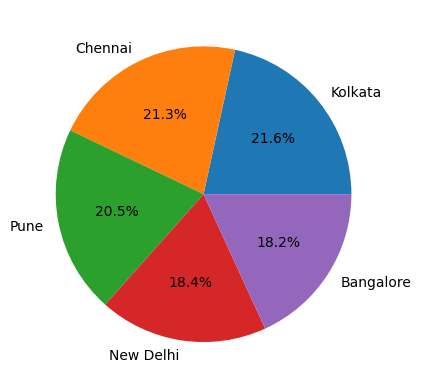

In [93]:
location = sample_380['Location'].value_counts()
plt.pie(location, labels=location.index, autopct='%1.1f%%')
plt.show()

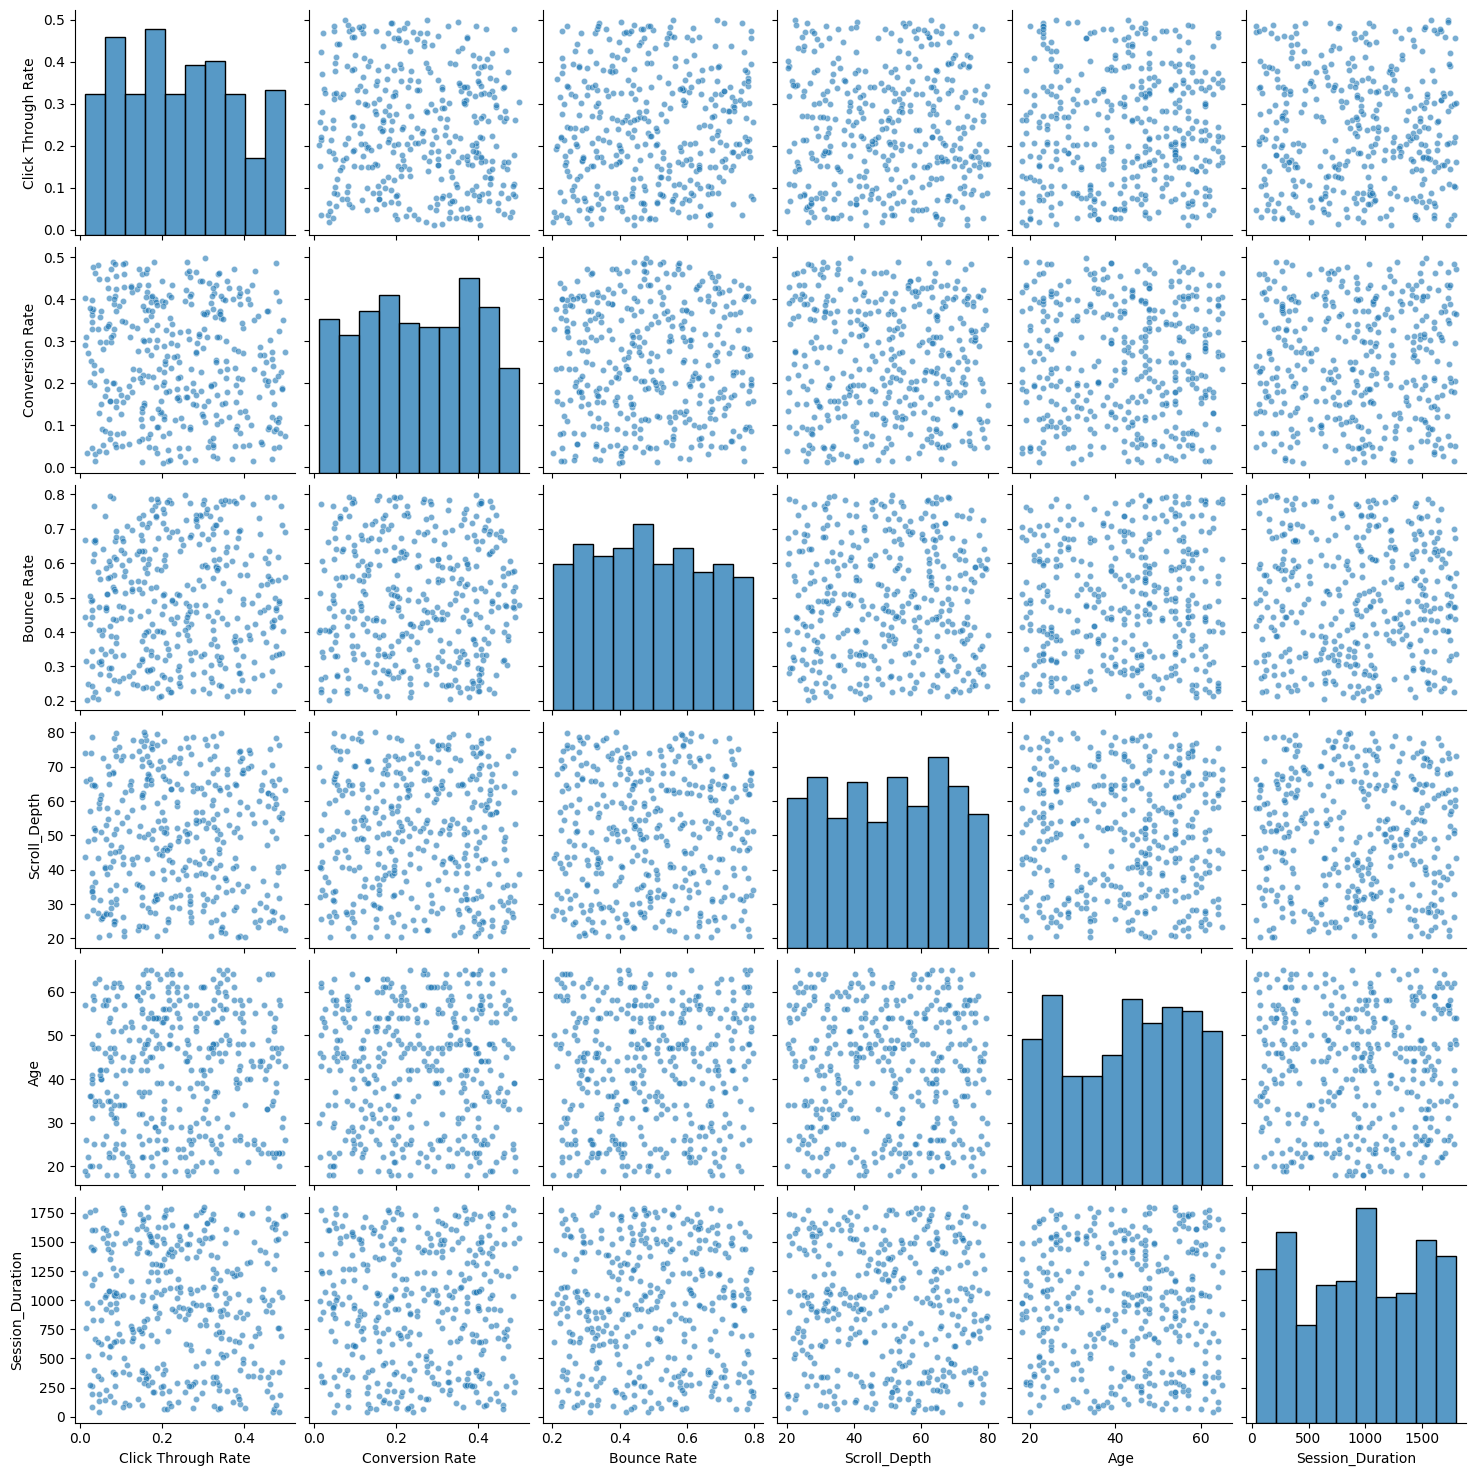

In [105]:
create_plots(sample_380, ['pairplot'])

Между собой метрики на исходной выборке не скоррелированы, от возраста также не зависят. 

# A/A тест

Сгенерируем равные группы для A/A теста и попробуем установить размеры выборок, ошибки 1 и 2 рода, детектируемый эффект.

In [119]:
# генерация групп для A/A теста из исходных данных
np.random.seed(42)
n = len(sample_380)
sample_380['group_aa'] = np.random.choice(['A1', 'A2'], size=n, p=[0.5, 0.5])

Рассчитаем метрики пользовательского поведения, которые планируем далее измерять в A\B тесте, для группы А1, используем их для формулирования предварительных гипотез на этапе А/А тестирования

In [120]:
a1_df = sample_380.loc[sample_380['group_aa'] == 'A1']
a2_df = sample_380.loc[sample_380['group_aa'] == 'A2']

Проверим правильность генерации

In [ ]:
a1_df.shape

(186, 11)

In [ ]:
a2_df.shape

(194, 11)

Сформулируем независимые гипотезы для трех метрик:

In [112]:
metrics_A1_df = a1_df[['Click Through Rate', 'Bounce Rate', 'Scroll_Depth']]

Важно учитывать возрастные особенности при использовании темной темы. У нас достаточно много пользователей от 30, предположим, что темная тема будет для них более комфортна для глаз, а значит, увеличит глубину скролла. 

In [ ]:
a1_df.loc[a1_df['Age'] >= 30].shape[0]

144

In [147]:
a1_df30 = a1_df.loc[a1_df['Age'] >= 30]

In [113]:
stats_A1 = create_stats_df(metrics_A1_df)
stats_A1

,Click Through Rate,Bounce Rate,Scroll_Depth
Среднее,0.239557,0.507877,48.836401
Дисперсия,0.019267,0.027935,298.873859
Мода,0.206408,0.317859,22.310718
Медиана,0.238907,0.521215,49.501293
1-й квартиль,0.118897,0.358607,33.645973
2-й квартиль,0.238907,0.521215,49.501293
3-й квартиль,0.341066,0.644653,64.520739
4-й квартиль,0.499080,0.797683,79.997108


Сформулируем предварительные гипотезы с учетом особенностей распределений: так как Scroll_Depth имеет высокую дисперсию, будем измерять медианную метрику

## Гипотезы на этапе А/А теста

Темная тема (Dark) увеличивает средний Click Through Rate на 15% (с 23.96% до 27.55%) при при α=0.05 и β=0.2

Светлая тема (Light) снижает средний Bounce Rate на 20% (с 50.79% до 40.63%) при α=0.05 и β=0.2

Для пользователей >30 лет Dark theme увеличивает медианную Scroll_Depth на 25% (с 49.50 до 61.88) 

Так как в реальных данных всегда присутствует шум, сгенерируем его с std = 0.02 для первых двух гипотез и 0.05 для третьей, так как дисперсия в этой выборке больше

In [122]:
noise_std = 0.02
noise = np.random.normal(loc=0, scale=noise_std, size=len(a2_df))

In [ ]:
# искусственно воссоздадим эффекты на выборке a2
ctr_a2 = a2_df['Click Through Rate']*(1.15+noise)
br_a2 = a2_df['Bounce Rate']*(1.20+noise)

In [142]:
a2_df_30 = a2_df.loc[a2_df['Age'] >= 30]

In [ ]:
# шум для scroll depth
noise_std = 0.05
noise = np.random.normal(loc=0, scale=noise_std, size=len(a2_df_30))

In [144]:
sd_a2 = a2_df_30['Scroll_Depth']*(1.25+noise)

Теперь рассчитаем стат.тесты на разных размерах выборок. Так как объем данных ограничен (что приближено к реальным условиям, так как за несколько недель A/B теста не всегда есть возможность набрать большую выборку), будем проводить стат.тесты на малой и средних выборках.

In [151]:
def efr_diff(s1 : Iterable, s2 : Iterable, h_metric = Literal['mean', 'median'], n_iterations = 100, alpha = 0.05):
  # рассчитывает эфронов доверительный интервал на основе бутстрепа
    diffs = []
    n1 = len(s1)
    n2 = len(s2)
    for _ in range(n_iterations):
        # бутстреп для двух сегментов
        sample1 = np.random.choice(s1, size=n1, replace=True)
        sample2 = np.random.choice(s2, size=n2, replace=True)
        # Вычисляем разницу статистик
        if h_metric =='mean': 
          diff = np.mean(sample1) - np.mean(sample2)

        elif h_metric =='median':
          diff = np.median(sample1) - np.median(sample2)

        diffs.append(diff)
    lower = np.percentile(diffs, 100*alpha/2)
    upper = np.percentile(diffs, 100*(1-alpha/2))

    print(f"95% эфронов интервал: ({round(lower, 3)}, {round(upper, 3)})")

In [166]:
def stattest_samples(s1, s2, stat_tests = List[Literal['ttest', 'mannwhitneyu', 'ks_2samp']], h_metric = Literal['mean', 'median'],  size = [20, 50, 100], generate = True):
    if generate: 
        for i in size:
                print(f'\nДля выборок размером {i}:')
                generated_a1 = np.random.choice(s1, size=i, replace=False)
                generated_a2 = np.random.choice(s2, size=i, replace=False)
                #доверительный интервал для статистики на основе бутстрепа
                efr_diff(generated_a1, generated_a2, h_metric)
                #стат тесты для независимых выборок
                if 'ttest' in stat_tests:
                        _, p_value = sts.ttest_ind(generated_a1, generated_a2, equal_var = False)
                        print(f"Для ttest p-value: {p_value}") 

                if 'mannwhitneyu' in stat_tests:
                        _, p_value = sts.mannwhitneyu(generated_a1, generated_a2)
                        print(f"Для теста Мана-Уитни p-value: {p_value}") 

                if 'ks_2samp' in stat_tests:
                        _, p_value = sts.ks_2samp(generated_a1, generated_a2)
                        print(f"Для теста Колмогорова-Смирнова p-value: {p_value}") 

    # для полной выборки
    print(f'\nДля полных выборок a1: {len(s1)}, a2: {len(s2)}')
    efr_diff(s1, s2, h_metric) #доверительный интервал для статистики на основе бутстрепа
    #стат тесты для независимых выборок
    if 'ttest' in stat_tests:
            _, p_value = sts.ttest_ind(s1, s2, equal_var = False)
            print(f"Для ttest p-value: {p_value}") 

    if 'mannwhitneyu' in stat_tests:
            _, p_value = sts.mannwhitneyu(s1, s2)
            print(f"Для теста Мана-Уитни p-value: {p_value}") 

    if 'ks_2samp' in stat_tests:
                _, p_value = sts.ks_2samp(s1, s2)
                print(f"Для теста Колмогорова-Смирнова p-value: {p_value}") 

## Результаты АА теста, гипотеза:

Темная тема (Dark) увеличивает средний Click Through Rate на 15% (с 23.96% до 27.55%) при при α=0.05 и β=0.2

In [165]:
stattest_samples(s1 = a1_df['Click Through Rate'].values,
                 s2 = ctr_a2,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric ='mean')


Для выборок размером 20:
95% эфронов интервал: (-0.196, 0.004)
Для ttest p-value: 0.08727508900357661
Для теста Мана-Уитни p-value: 0.11355139298344043
Для теста Колмогорова-Смирнова p-value: 0.17453300569806826

Для выборок размером 50:
95% эфронов интервал: (-0.071, 0.032)
Для ttest p-value: 0.5080877475672058
Для теста Мана-Уитни p-value: 0.5979316591936927
Для теста Колмогорова-Смирнова p-value: 0.3959398631708505

Для выборок размером 100:
95% эфронов интервал: (-0.082, -0.017)
Для ttest p-value: 0.014308240113811084
Для теста Мана-Уитни p-value: 0.022123915583805918
Для теста Колмогорова-Смирнова p-value: 0.05390207893129876

Для полных выборок a1: 186:, a2: 194
95% эфронов интервал: (-0.066, -0.006)
Для ttest p-value: 0.00893038419425787
Для теста Мана-Уитни p-value: 0.01691949875750765
Для теста Колмогорова-Смирнова p-value: 0.11389017565672414


## Выводы по результатам АА теста для первой гипотезы

Таким образом, для n = 100 и выше разница статистически значима при α = 0.05. Эфронов интервал не включает 0, что тоже говорит о реальной разнице. ttest показывает стабильный результат, и хотя его выводы сопоставимы с результатами Мана-Уитни, помним, что гипотеза построена о средних, в то время как тест Мана-уитни относится к сдвигам распределения. Как и ожидалось, тест Колмогорова-Смирнова показывает нестабильный результат, он будет интерпретируем для гипотез о распределении и бОльших размеров выборок. 

Для A/B теста будем оценивать ttest и эфронов интервал на выборке 100-150 наблюдений, гипотезу 1 оставляем в первоначальном виде, детектируемые эффекты и расчетные ошибки не изменяем.

## Результаты АА теста: 

Светлая тема (Light) снижает средний Bounce Rate на 20% (с 50.79% до 40.63%) при α=0.05 и β=0.2

In [161]:
stattest_samples(s1 = a1_df['Bounce Rate'].values,
                 s2 = br_a2,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric = 'mean')

Для выборок размером 20:
95% эфронов интервал: (-0.301, -0.032)
Для ttest p-value: 0.0356039718990901
Для теста Мана-Уитни p-value: 0.03604832666418314
Для теста Колмогорова-Смирнова p-value: 0.08105771161340149
Для выборок размером 50:
95% эфронов интервал: (-0.123, 0.046)
Для ttest p-value: 0.20457034308767688
Для теста Мана-Уитни p-value: 0.28996365553878367
Для теста Колмогорова-Смирнова p-value: 0.5486851446031328
Для выборок размером 100:
95% эфронов интервал: (-0.129, -0.043)
Для ttest p-value: 0.0015719057620217141
Для теста Мана-Уитни p-value: 0.007936908057450544
Для теста Колмогорова-Смирнова p-value: 0.05390207893129876
Для полных выборок a1: 186:, a2: 194
95% эфронов интервал: (-0.104, -0.035)
Для ttest p-value: 0.00034314614626083516
Для теста Мана-Уитни p-value: 0.003159119842313043
Для теста Колмогорова-Смирнова p-value: 0.0011102618253108305


## Выводы по результатам АА теста для второй гипотезы

Гипотеза о том, что светлая тема снижает Bounce Rate на 20%, подтверждается при размере выборки 100+. Для меньших выборок результат менее надёжен, на выборке 20 эффект детектируется, а на 50 пропадает. Аналогично с первой метрикой, тесты Мана-Уитни и Колмогорова-Смирнова не подходят для тестирования выбранной гипотезы. 

Для A/B теста будем оценивать ttest и эфронов интервал на выборке 100-150 наблюдений, гипотезу 2 оставляем в первоначальном виде, детектируемые эффекты и расчетные ошибки не изменяем.

## Результаты АА теста для третьей гипотезы:

Для пользователей >30 лет Dark theme увеличивает медианную Scroll_Depth на 25% (с 49.50 до 61.88) 

In [162]:
stattest_samples(s1 = a1_df30['Scroll_Depth'].values,
                 s2 = sd_a2,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric = 'median')

Для выборок размером 20:
95% эфронов интервал: (-41.471, -5.361)
Для ttest p-value: 0.001500842251363023
Для теста Мана-Уитни p-value: 0.0014809771857968636
Для теста Колмогорова-Смирнова p-value: 0.012298612583953778
Для выборок размером 50:
95% эфронов интервал: (-24.878, -0.449)
Для ttest p-value: 0.002283644937740325
Для теста Мана-Уитни p-value: 0.0035838877381762085
Для теста Колмогорова-Смирнова p-value: 0.005841778142694731
Для выборок размером 100:
95% эфронов интервал: (-25.121, -5.368)
Для ttest p-value: 3.397546959827623e-07
Для теста Мана-Уитни p-value: 1.5293060747718064e-06
Для теста Колмогорова-Смирнова p-value: 0.0002248739317492479
Для полных выборок a1: 144:, a2: 143
95% эфронов интервал: (-22.167, -8.814)
Для ttest p-value: 3.17660369435217e-10
Для теста Мана-Уитни p-value: 4.752202832800907e-09
Для теста Колмогорова-Смирнова p-value: 1.700671722418489e-06


## Выводы по результатам АА теста для третьей гипотезы

Гипотеза о том, что темная тема увеличивает медианную Scroll Depth на 25%, подтверждается при любом размере выборки. Результаты тестов на разных уровнях выборки показывают значимость разницы между группами. 

Тем не менее, размер выборки 20-50 в реальных условиях может отличаться гораздо сильнее, также помним о высокой дисперсии в этой группе.  Также выберем статистический тест: для гипотезы H0 о равенстве медиан интерпретируем будет тест Колмогорова-Смирнова, который проверяет идентичность распределений. Также рассчитаем Мана-Уитни дополнительно, но помним, что равенство медиан этот тест не проверяет. 

Для A/B теста будем оценивать тест Колмогорова-Смирнова и эфронов интервал на выборке около 100 наблюдений, гипотезу 3 оставляем в первоначальном виде, детектируемые эффекты и расчетные ошибки не изменяем.

# Гипотезы для А/B теста, A/B тест

Гипотеза 1

H0: средние значения Click Through Rate для групп со светлой и темной темой равны

H1: Темная тема (Dark) увеличивает средний Click Through Rate на 15% при при α=0.05 и β=0.2

Гипотеза 2

H0: средние значения Bounce Rate для групп со светлой и темной темой равны

H1: Светлая тема (Light) снижает средний Bounce Rate на 20% при α=0.05 и β=0.2

Гипотеза 3

H0: медианы Scroll_Depth для групп со светлой и темной темой равны

H1: Для пользователей >30 лет Dark theme увеличивает медианную Scroll_Depth на 25% 

In [ ]:
light_df.drop(sample_380.index, inplace = True)

In [263]:
sample_dark= dark_df.sample(n=120)
sample_dark_stats = sample_dark[['Click Through Rate', 'Bounce Rate', 'Scroll_Depth']]
light_df_stats = light_df[['Click Through Rate', 'Bounce Rate', 'Scroll_Depth']]

In [264]:
stattest_samples(s1 = light_df['Click Through Rate'].values,
                 s2 = sample_dark['Click Through Rate'].values,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric = 'mean', 
                 generate=False)


Для полных выборок a1: 106, a2: 120
95% эфронов интервал: (-0.02, 0.058)
Для ttest p-value: 0.5951283635171986
Для теста Мана-Уитни p-value: 0.6737748315328831
Для теста Колмогорова-Смирнова p-value: 0.4854151582643362


In [265]:
stattest_samples(s1 = light_df['Bounce Rate'].values,
                 s2 = sample_dark['Bounce Rate'].values,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric = 'mean', 
                 generate=False)


Для полных выборок a1: 106, a2: 120
95% эфронов интервал: (-0.034, 0.056)
Для ttest p-value: 0.7630163498958137
Для теста Мана-Уитни p-value: 0.9293365990099989
Для теста Колмогорова-Смирнова p-value: 0.530363797611524


In [266]:
sample_dark_30 = sample_dark.loc[sample_dark['Age'] >= 30]
sample_light_30 = light_df.loc[light_df['Age'] >= 30]

In [267]:
stattest_samples(s1 = sample_light_30['Scroll_Depth'].values,
                 s2 = sample_dark_30['Scroll_Depth'].values,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric = 'median', 
                 generate=False)


Для полных выборок a1: 76, a2: 93
95% эфронов интервал: (-2.014, 13.659)
Для ttest p-value: 0.2648476182001701
Для теста Мана-Уитни p-value: 0.29773918184227977
Для теста Колмогорова-Смирнова p-value: 0.07256606938556377


Сводная таблица статистик по группам

In [268]:
create_stats_df(sample_dark_stats)

,Click Through Rate,Bounce Rate,Scroll_Depth
Среднее,0.258516,0.509967,51.036208
Дисперсия,0.020888,0.036683,230.033287
Мода,0.438531,0.446540,40.941190
Медиана,0.265800,0.540640,49.757457
1-й квартиль,0.131921,0.312374,41.293153
2-й квартиль,0.265800,0.540640,49.757457
3-й квартиль,0.372664,0.672112,63.708258
4-й квартиль,0.498610,0.799658,79.811019


In [269]:
create_stats_df(light_df_stats)

,Click Through Rate,Bounce Rate,Scroll_Depth
Среднее,0.268587,0.517242,52.880945
Дисперсия,0.019511,0.029149,264.854725
Мода,0.113932,0.732759,61.858568
Медиана,0.255660,0.542047,52.837299
1-й квартиль,0.179950,0.387416,40.635426
2-й квартиль,0.255660,0.542047,52.837299
3-й квартиль,0.389672,0.658806,66.237236
4-й квартиль,0.498659,0.791984,78.538754


# Интерпретация результатов

Ни один из статистических тестов не показал значимых различий. Минимальные детектируемые эффекты также не были достигнуты. Так как в тесте вообще не было статистически значимой разницы между группами, дальнейшие эксперименты с выбранными метриками не имеют смысла. 

Тем не менее, на исторических данных можно провести ряд других тестов: например, оценить метрику Session_Duration, она тоже может свидетельствовать об удобстве использования темной темы. В рамках данного эксперимента также интересно посмотреть на временные данные: увеличивались ли метрики со временем? Возможно, пользователям нужно было время, чтобы привыкнуть к теме, тогда метрики будут расти со временем, и могут просто не достигнуть статистически значимого эффекта за отведенное время тестирования. 

Для бизнеса хорошим решением будет оставить возможность переключения на темную тему, не убирая полностью светлую, и дополнительно замерить другие метрики: CSAT, например. Возможно, пользователи не стали заказывать больше или проводить время в приложении дольше, но они больше довольны опытом взаимодействия с продуктом. Отсутствие эффекта в случае темной темы также может считаться положительным результатом: метрики не упали, темная тема не уронила показатели, хотя довольно часто новый дизайн вызывает у пользователей негативный эффект, так как нарушает привычные паттерны поведения. 

Некоторые из предположений можем проверить, если считать, что исходные данные - уже результат A/B теста.

Мы можем сразу проверить теорию о том, что бОльший размер выборки мог показать другие результаты

In [272]:
light_df = df.loc[df['Theme'] == "Light Theme"]
dark_df = df.loc[df['Theme'] == "Dark Theme"]

In [273]:
sample_dark_30 = dark_df.loc[dark_df['Age'] >= 30]
sample_light_30 = light_df.loc[light_df['Age'] >= 30]

In [274]:
stattest_samples(s1 = light_df['Click Through Rate'].values,
                 s2 = dark_df['Click Through Rate'].values,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric = 'mean', 
                 generate=False)


Для полных выборок a1: 486, a2: 514
95% эфронов интервал: (-0.032, -0.003)
Для ttest p-value: 0.04818435371010704
Для теста Мана-Уитни p-value: 0.04515110315308348
Для теста Колмогорова-Смирнова p-value: 0.04008476270097577


In [275]:
stattest_samples(s1 = light_df['Bounce Rate'].values,
                 s2 = dark_df['Bounce Rate'].values,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric = 'mean', 
                 generate=False)


Для полных выборок a1: 486, a2: 514
95% эфронов интервал: (-0.033, 0.006)
Для ttest p-value: 0.229692077505148
Для теста Мана-Уитни p-value: 0.20634524595744597
Для теста Колмогорова-Смирнова p-value: 0.13681094147713696


In [276]:
stattest_samples(s1 = sample_light_30['Scroll_Depth'].values,
                 s2 = sample_dark_30['Scroll_Depth'].values,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric = 'median', 
                 generate=False)


Для полных выборок a1: 363, a2: 369
95% эфронов интервал: (-2.491, 4.32)
Для ttest p-value: 0.4878806270265097
Для теста Мана-Уитни p-value: 0.5198253406245434
Для теста Колмогорова-Смирнова p-value: 0.5537227411448448


Получаем слабо отличающийся результат для CTR, на группе из 500 человек уже выявляется разница между темной и светлой темой в Click Through Rate, хотя 95% доверительный интервал очень близок к 0, результат слабый. В таблицах метрик видим, что значения действительно не так сильно отличаются

In [277]:
create_stats_df(dark_df[metrics_df.columns])

,Click Through Rate,Bounce Rate,Scroll_Depth,Conversion Rate,Session_Duration
Среднее,0.264501,0.512115,49.926404,0.251282,919.482490
Дисперсия,0.019836,0.030551,282.265184,0.019866,260394.616652
Мода,0.323352,0.296543,45.737376,0.178763,563.000000
Медиана,0.272815,0.532202,50.017310,0.244630,912.500000
1-й квартиль,0.143888,0.356787,35.627980,0.128340,462.000000
2-й квартиль,0.272815,0.532202,50.017310,0.244630,912.500000
3-й квартиль,0.382541,0.656779,63.931269,0.370905,1374.500000
4-й квартиль,0.499989,0.799658,79.824726,0.498916,1797.000000


In [278]:
create_stats_df(light_df[metrics_df.columns])

,Click Through Rate,Bounce Rate,Scroll_Depth,Conversion Rate,Session_Duration
Среднее,0.247109,0.499035,50.735232,0.255459,930.833333
Дисперсия,0.018812,0.028673,289.070549,0.018828,256549.611340
Мода,0.054920,0.405085,72.489458,0.282367,1535.000000
Медиана,0.236563,0.496821,51.499497,0.260194,952.000000
1-й квартиль,0.139769,0.351643,35.733453,0.141956,473.750000
2-й квартиль,0.236563,0.496821,51.499497,0.260194,952.000000
3-й квартиль,0.353777,0.637910,64.953740,0.375787,1376.000000
4-й квартиль,0.499328,0.797683,79.997108,0.498660,1797.000000


Проверим также теорию о том, что мог быть эффект для других показателей

In [281]:
stattest_samples(s1 = light_df['Session_Duration'].values,
                 s2 = dark_df['Session_Duration'].values,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric = 'median', 
                 generate=False)


Для полных выборок a1: 486, a2: 514
95% эфронов интервал: (-58.6, 120.725)
Для ttest p-value: 0.7242292543366338
Для теста Мана-Уитни p-value: 0.7189033061927399
Для теста Колмогорова-Смирнова p-value: 0.8140509182349521


In [284]:
stattest_samples(s1 = light_df['Conversion Rate'].values,
                 s2 = dark_df['Conversion Rate'].values,
                 stat_tests = ['ttest', 'mannwhitneyu', 'ks_2samp'],
                 h_metric = 'mean', 
                 generate=False)


Для полных выборок a1: 486, a2: 514
95% эфронов интервал: (-0.013, 0.025)
Для ttest p-value: 0.6349982678451778
Для теста Мана-Уитни p-value: 0.6136737951955493
Для теста Колмогорова-Смирнова p-value: 0.891718718379147


Таким образом, для выбранных метрик не видим начимой разницы на A/B тесте в варианте с рассчитанной выборкой 100 пользователей в группе, выборка в 500 пользователей также не дала бы другой результат. Это подтверждает правильность предварительного расчета выборок и эффективность А\А тестирования: мы рассчитали, что 100-150 пользователей будет достаточно, чтобы увидеть эффект. Действительно, при отсутствии эффекта на выборке в 100 пользователей при увеличении выборки до 500 эффект не появился. Мы потенциально сэкономили бизнесу время и ресурсы и подобрали оптимальный размер выборки для A/B теста. 